# COVID-19 Detection using VGG-16

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model, Input
from keras.layers import Dense,Conv2D,Dropout,BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16

# Supress info, warnings and error messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
disease_types = ['COVID', 'non-COVID']

train_dir = data_dir = '../input/sarscov2-ctscan-dataset'

train_data = []

for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
        
train = pd.DataFrame(train_data, columns = ['File', 'ID','Disease Type'])
train

,File,ID,Disease Type
0,COVID/Covid (230).png,0,COVID
1,COVID/Covid (1195).png,0,COVID
2,COVID/Covid (182).png,0,COVID
3,COVID/Covid (817).png,0,COVID
4,COVID/Covid (631).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (479).png,1,non-COVID
2477,non-COVID/Non-Covid (659).png,1,non-COVID
2478,non-COVID/Non-Covid (689).png,1,non-COVID
2479,non-COVID/Non-Covid (212).png,1,non-COVID


Text(0.5, 1.0, 'Frequency Histogram of Disease IDs')

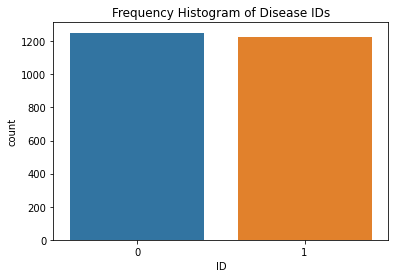

In [3]:
Seed = 7
IMAGE_SIZE = 224
train = train.sample(frac = 1, replace=False, random_state = Seed) 
train = train.reset_index(drop = True) # Reset indices (row numbers)

sns.countplot(x = "ID", data = train).set_title("Frequency Histogram of Disease IDs")

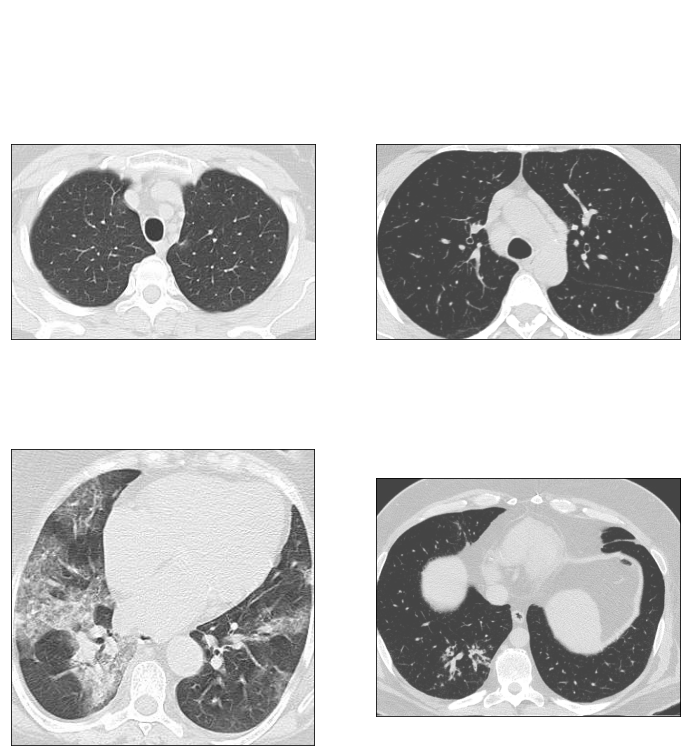

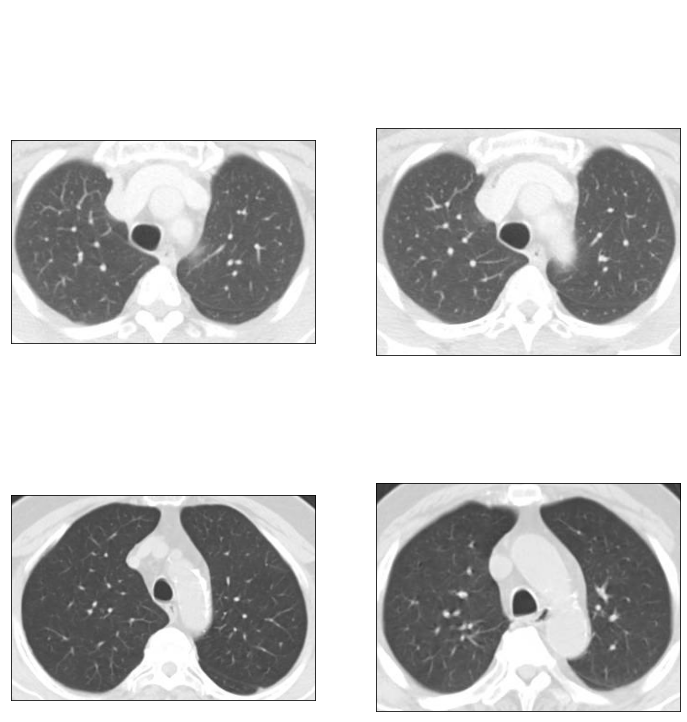

In [4]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    
    n = 0
    fig.suptitle(defect_types, fontsize = 22, color = "white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
            
# Displays first n images of class from training set
plot_defects('COVID', 2, 2)
plot_defects('non-COVID', 2, 2)

In [5]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag

# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [6]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

# Normalize the data
X_Train = X_train / 255.0
print('Train Shape:', X_Train.shape)

Y_train = to_categorical(train['ID'].values, num_classes = 2)


Train Shape: (2481, 224, 224, 3)


In [7]:
# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train,
                                                  Y_train,
                                                  test_size = 0.2,
                                                  random_state = Seed)

print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1984, 224, 224, 3)
X_val: (497, 224, 224, 3)
Y_train: (1984, 2)
Y_val: (497, 2)


In [8]:
def build_vgg(IMAGE_SIZE, channels):
    
    VGG = VGG16(weights='imagenet', include_top = False)
    
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = VGG(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)

    output = Dense(2,activation = 'softmax')(x)
 

    # model
    model = Model(input,output)
   
    
    optimizer = Adam(learning_rate= 0.003, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0)
    model.compile(loss = 'categorical_crossentropy', optimizer =optimizer, metrics = ['accuracy'])
    model.summary()
    
    return model

In [9]:
channels = 3

model = build_vgg(IMAGE_SIZE, channels)
annealer = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.70, patience = 5, verbose = 1, min_lr = 1e-4)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range = 360, # Degree range for random rotations
                        width_shift_range = 0.2, # Range for random horizontal shifts
                        height_shift_range = 0.2, # Range for random vertical shifts
                        zoom_range = 0.2, # Range for random zoom
                        horizontal_flip = True, # Randomly flip inputs horizontally
                        vertical_flip = True) # Randomly flip inputs vertically

datagen.fit(X_train)


58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       84        
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
______________________________________________________________

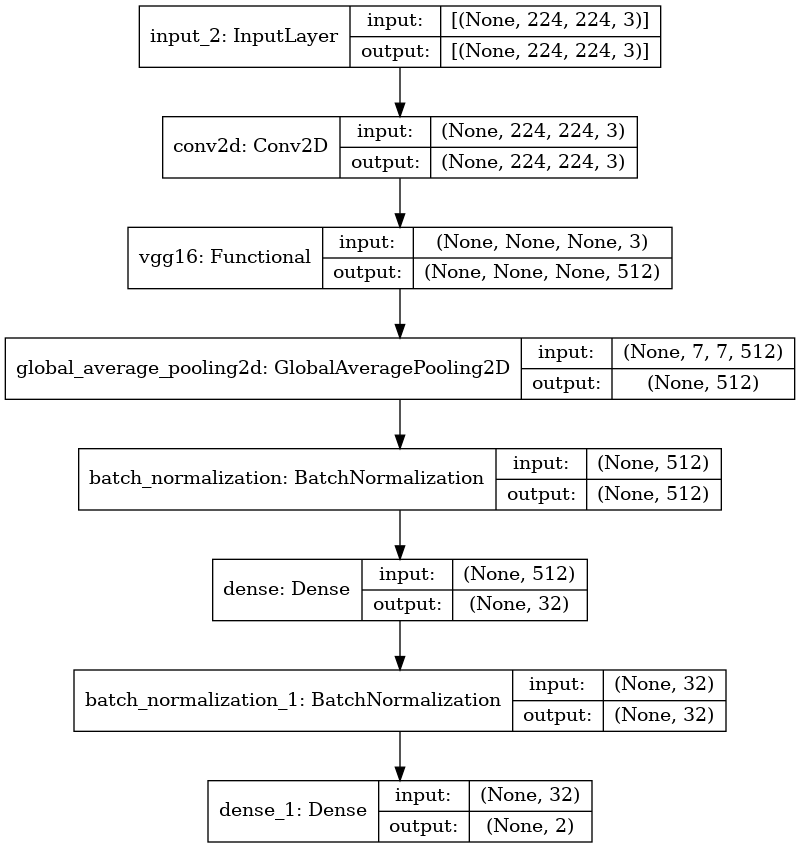

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'convnet.png', show_shapes = True, show_layer_names = True)

In [11]:
BATCH_SIZE = 32
EPOCHS = 65


# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size = BATCH_SIZE),
               steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
               epochs = EPOCHS,
               verbose = 1,
               callbacks = [annealer],
               validation_data = (X_val, Y_val))

Epoch 1/65
62/62 [==============================] - 44s 508ms/step - loss: 0.4985 - accuracy: 0.7686 - val_loss: 0.5105 - val_accuracy: 0.7264
Epoch 2/65
62/62 [==============================] - 25s 403ms/step - loss: 0.3952 - accuracy: 0.8402 - val_loss: 0.4349 - val_accuracy: 0.8048
Epoch 3/65
62/62 [==============================] - 25s 401ms/step - loss: 0.3441 - accuracy: 0.8674 - val_loss: 0.5873 - val_accuracy: 0.7445
Epoch 4/65
62/62 [==============================] - 26s 412ms/step - loss: 0.3264 - accuracy: 0.8654 - val_loss: 0.5194 - val_accuracy: 0.8330
Epoch 5/65
62/62 [==============================] - 26s 417ms/step - loss: 0.2945 - accuracy: 0.8881 - val_loss: 0.9491 - val_accuracy: 0.6942
Epoch 6/65
62/62 [==============================] - 26s 413ms/step - loss: 0.3145 - accuracy: 0.8669 - val_loss: 0.4026 - val_accuracy: 0.8712
Epoch 7/65
62/62 [==============================] - 25s 406ms/step - loss: 0.2554 - accuracy: 0.9037 - val_loss: 0.2707 - val_accuracy: 0.9175

In [12]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 1s 66ms/step - loss: 0.0499 - accuracy: 0.9839
Final Loss: 0.049928922206163406, Final Accuracy: 0.9839034080505371


Text(0.5, 145.31999999999996, 'Predicted')

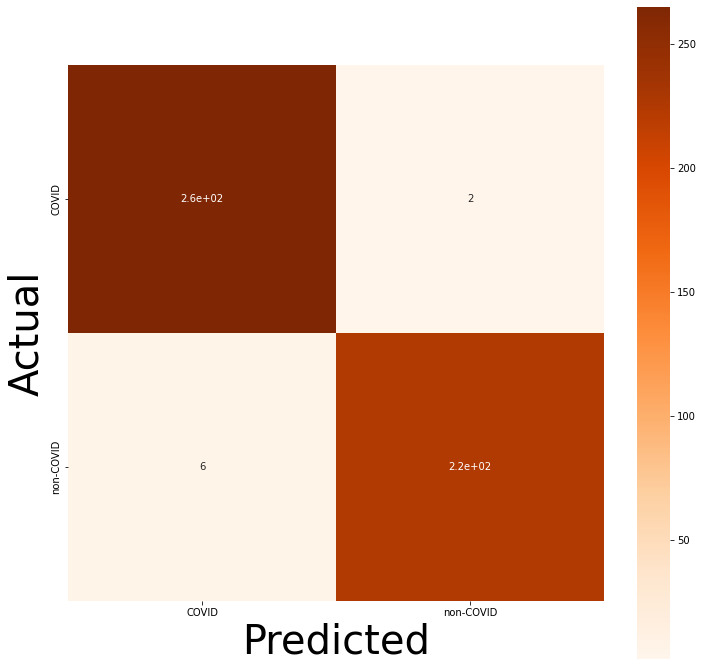

In [13]:
Y_pred = model.predict(X_val)
Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Oranges, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

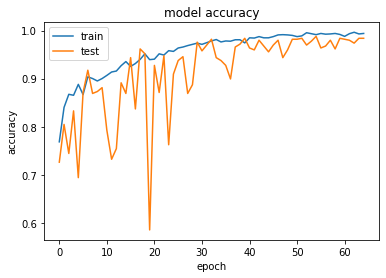

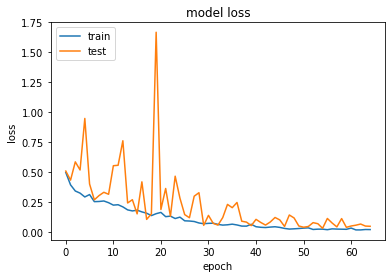

In [14]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()